Now, I'll attempt to use my logistic regression implementation to model some healthcare data. In this case, we'll be predicting whether a patient has diabetes based on 8 features. These include the number of times they've been pregnant, blood glucose level, skin thickness, blood insulin levels, BMI, diabetes pedigree function (an estimation of a patient's risk of getting diabetes based on family history), and age. 

In [30]:
# to access my stuff
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from models import LogisticRegressionModel
from utils.data_utils import split_dataset

import copy

In [31]:
# load data
data_path = 'datasets/diabetes.csv'
df = pd.read_csv(data_path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [32]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

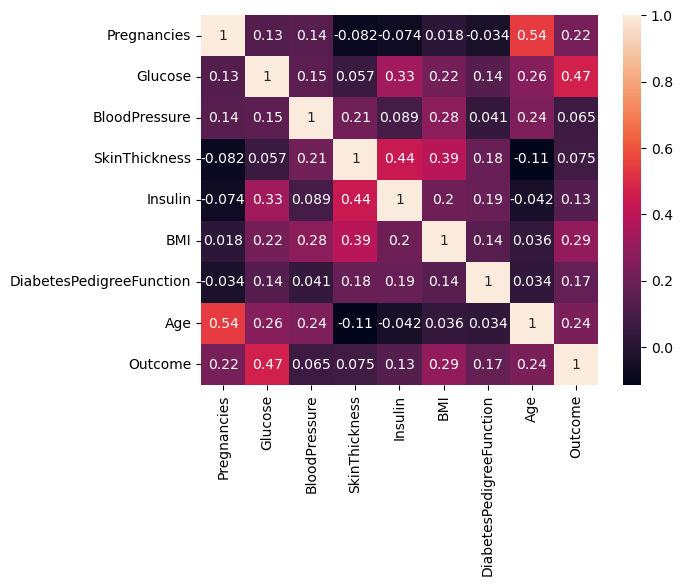

In [33]:
# checking for multicollinearity
sns.heatmap(df.corr(), annot=True)

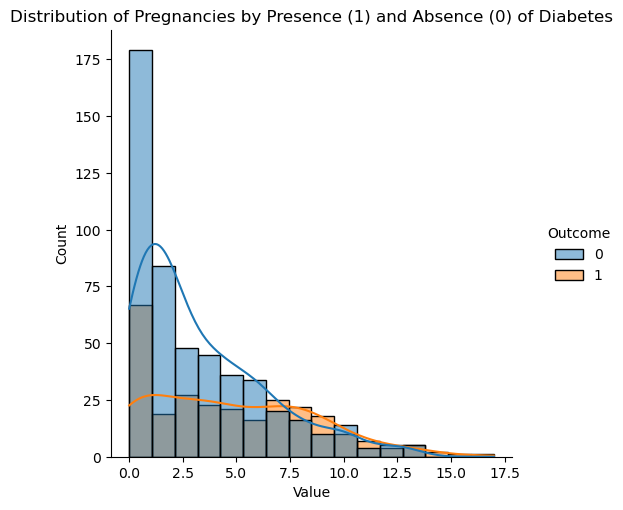

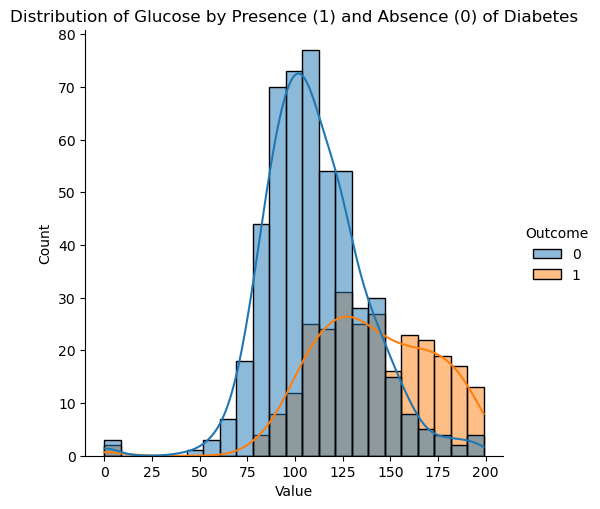

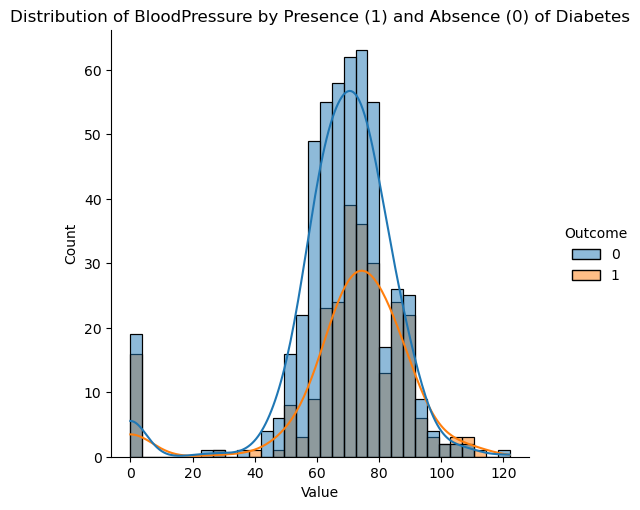

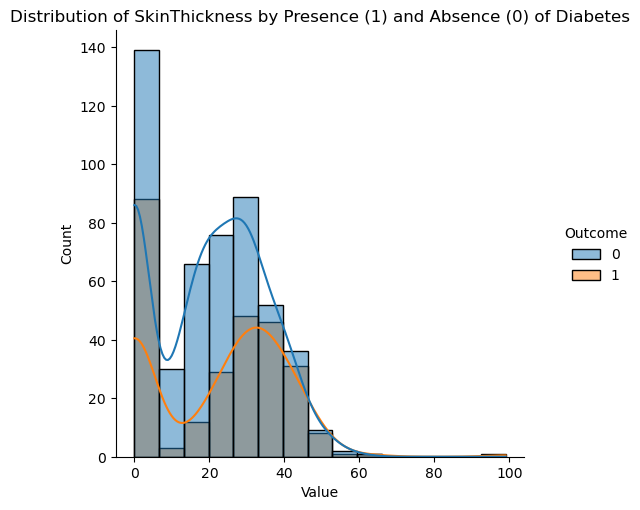

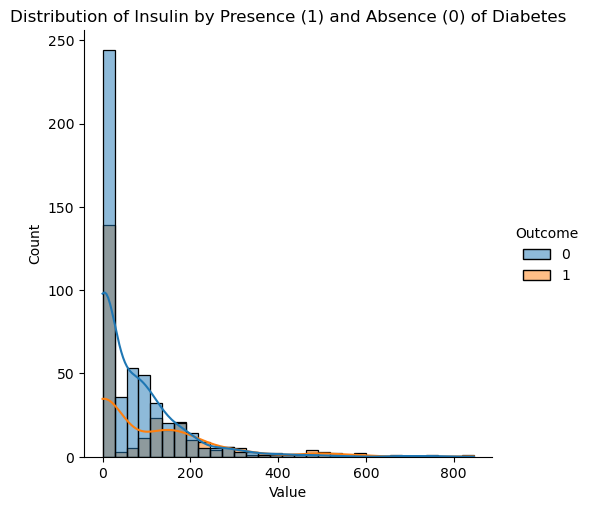

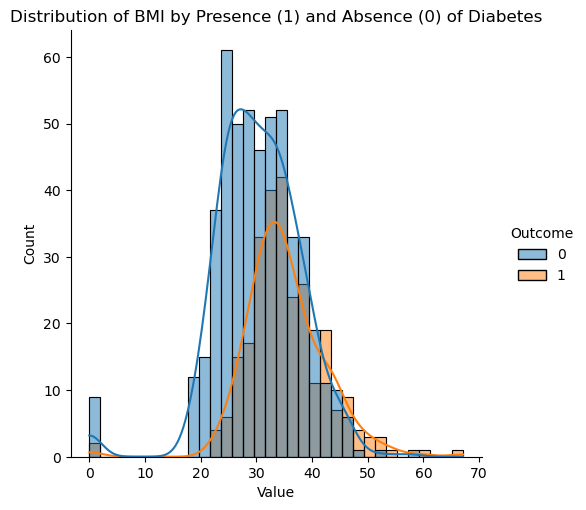

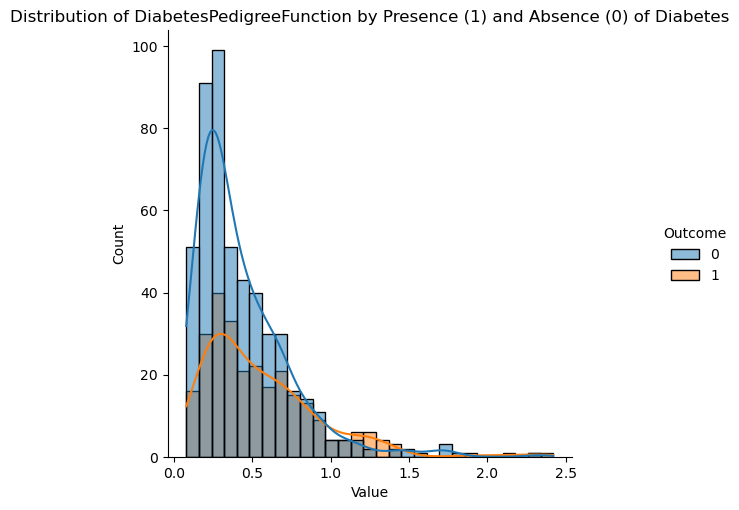

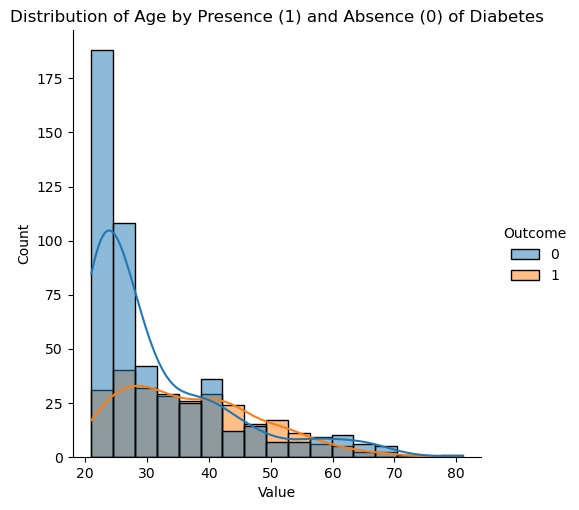

In [34]:
# visualizing feature distributions

features = df.columns[:-1]

for feature in features:
    sns.displot(data = df, x = feature, hue = 'Outcome', kde=True)
    plt.title(f'Distribution of {feature} by Presence (1) and Absence (0) of Diabetes')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()

# Naive Model (no imputing)

In [35]:
X = df[features].values
y = df['Outcome'].values

X_train, y_train, X_test, y_test = split_dataset(X, y, test_size=0.2, shuffle=True)

In [36]:
model = LogisticRegressionModel(num_features=len(features))
model.fit(X_train, y_train, num_iterations=100_000, lr=0.001)
print(f'Model test accuracy: {model.accuracy(X_test, y_test)}')
print(f'Model test cross entropy (log) loss: {model.loss(X_test, y_test)}')

Fitting model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 87540.53it/s]

Model test accuracy: 0.6753246753246753
Model test cross entropy (log) loss: 0.5949655320235588


In [37]:
# loss for both classes
loss_negative = model.loss(X_test[y_test == 0], y_test[y_test == 0])
loss_positive = model.loss(X_test[y_test == 1], y_test[y_test == 1])

print(f'Model test cross entropy (log) loss for no dibetes: {loss_negative}')
print(f'Model test cross entropy (log) loss for (positive) dibetes: {loss_positive}')

Model test cross entropy (log) loss for no dibetes: 0.4832806336256035
Model test cross entropy (log) loss for (positive) dibetes: 0.820525228788057


In [38]:
# accuracy for both classes
accuracy_negative = model.accuracy(X_test[y_test == 0], y_test[y_test == 0])
accuracy_positive = model.accuracy(X_test[y_test == 1], y_test[y_test == 1])

print(f'Model test accuracy for no dibetes: {accuracy_negative}')
print(f'Model test accuracy for (positive) dibetes: {accuracy_positive}')

Model test accuracy for no dibetes: 0.7669902912621359
Model test accuracy for (positive) dibetes: 0.49019607843137253


# Dealing with missing values

There are several features, namely insulin, blood pressure, glucose, BMI, and skin thickness for which there are a significant number of 0 values. In context, it's obvious why this means that a measurement was not taken and these 0 values are equivalent to null values; i. e. it is not physically possible to have a blood glucose of 0. For this reason, I'll try and impute the means based on training data and see how it affects the model's accuracy and loss. 

In [39]:
features_with_null_values = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for feature in features_with_null_values:
    print(f'Number of missing values for {feature}: {sum(df[feature] == 0)}')

Number of missing values for Glucose: 5
Number of missing values for BloodPressure: 35
Number of missing values for SkinThickness: 227
Number of missing values for Insulin: 374
Number of missing values for BMI: 11


In [40]:
# get mean from train set, impute it to both train and test data

column_names = list(df.columns)
null_feature_idx_list = [column_names.index(feature) for feature in features_with_null_values]

X_train_v2 = copy.deepcopy(X_train) # so I don't screw up my data 
X_test_v2 = copy.deepcopy(X_test)

for feature_idx in null_feature_idx_list:
    # get values for feature where not 0 in original data
    feature_train = X_train[X_train[:, feature_idx] != 0][:, feature_idx]

    # imputing mean to train data
    mean_feature_train = np.mean(feature_train)
    
    X_train_v2[X_train_v2[:, feature_idx] == 0, feature_idx] = mean_feature_train
    
    # impute mean from train set into test set
    X_test_v2[X_test_v2[:, feature_idx] == 0, feature_idx] = mean_feature_train

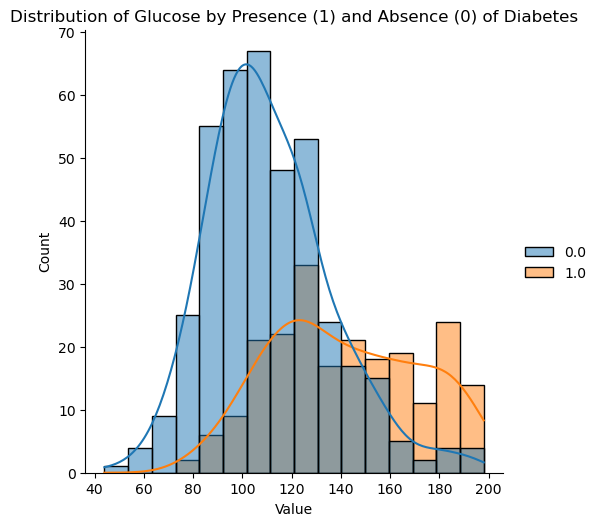

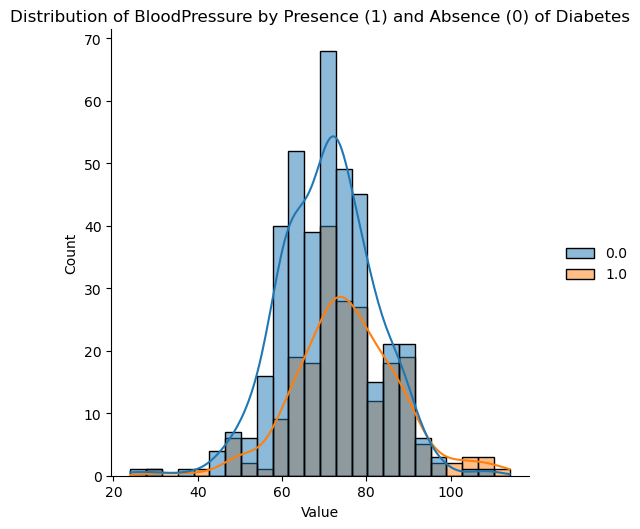

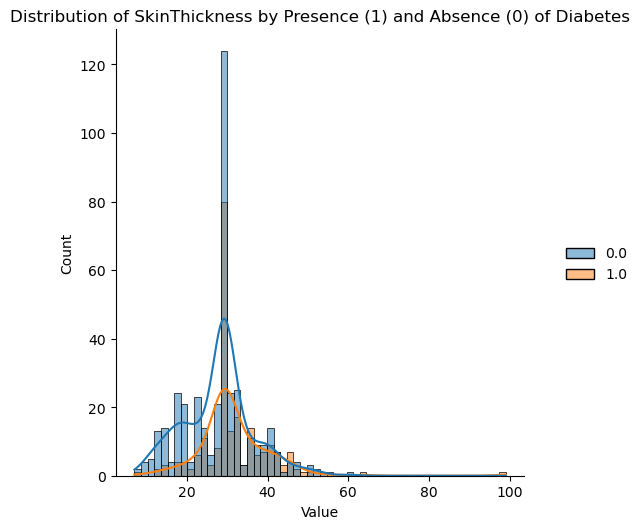

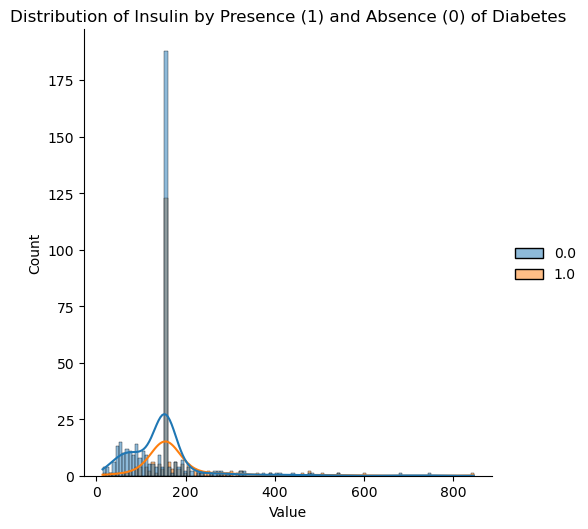

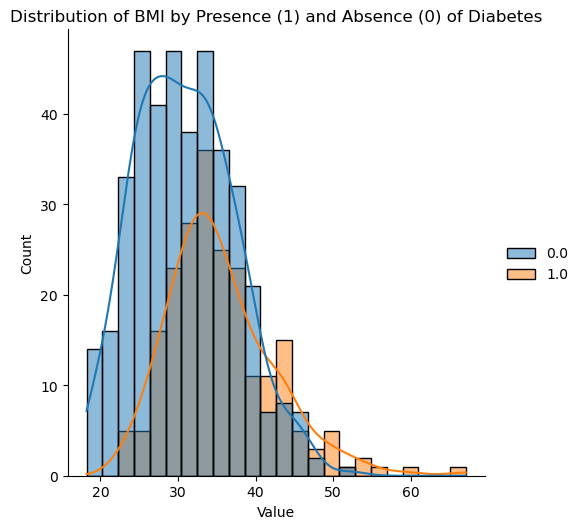

In [41]:
# visualizing the change to our data 

for feature_idx in null_feature_idx_list:
    feature_data = X_train_v2[:, feature_idx]
    
    sns.displot(x=feature_data, hue = y_train, kde=True)
    plt.title(f'Distribution of {features[feature_idx]} by Presence (1) and Absence (0) of Diabetes')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.show()

In [42]:
model = LogisticRegressionModel(num_features=8)

model.fit(X_train_v2, y_train, num_iterations=100_000, lr=0.001)
print(f'Model test accuracy: {model.accuracy(X_test, y_test)}')
print(f'Model test cross entropy (log) loss: {model.loss(X_test_v2, y_test)}')

# loss for both classes
loss_negative = model.loss(X_test_v2[y_test == 0], y_test[y_test == 0])
loss_positive = model.loss(X_test_v2[y_test == 1], y_test[y_test == 1])

print(f'Model test cross entropy (log) loss for no dibetes: {loss_negative}')
print(f'Model test cross entropy (log) loss for (positive) dibetes: {loss_positive}')

# accuracy for both classes
accuracy_negative = model.accuracy(X_test_v2[y_test == 0], y_test[y_test == 0])
accuracy_positive = model.accuracy(X_test_v2[y_test == 1], y_test[y_test == 1])

print(f'Model test accuracy for no dibetes: {accuracy_negative}')
print(f'Model test accuracy for (positive) dibetes: {accuracy_positive}')

Fitting model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 85701.13it/s]

Model test accuracy: 0.6558441558441559
Model test cross entropy (log) loss: 0.6584980175087078
Model test cross entropy (log) loss for no dibetes: 0.545664246911533
Model test cross entropy (log) loss for (positive) dibetes: 0.8863779855775118
Model test accuracy for no dibetes: 0.7281553398058253
Model test accuracy for (positive) dibetes: 0.5294117647058824


Huh, it actually made my model slightly worse. Oh well :)